In [1]:
import cv2
import numpy as np


In [2]:
cfg_file = "yolov3.cfg"
weight_file = "yolov3.weights"
class_file = "coco.names"

# Verify file existence
import os
for f in [cfg_file, weight_file, class_file]:
    print(f, "exists:", os.path.exists(f))


yolov3.cfg exists: True
yolov3.weights exists: True
coco.names exists: True


In [3]:
net = cv2.dnn.readNet(weight_file, cfg_file)
with open(class_file, "r") as f:
    classes = [line.strip() for line in f.readlines()]


In [8]:
image_path = "hit.jpg"  # <-- your test image here
image = cv2.imread(image_path)

if image is None:
    print("❌ Error: Could not read image. Check the path.")
else:
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1/255, (416,416), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)


In [9]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

outputs = net.forward(output_layers)

boxes, confidences, class_ids = [], [], []

for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


In [10]:
# Apply Non-Max Suppression (to remove overlapping boxes)
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Make sure indices is a flat list of integers (works across OpenCV versions)
if len(indices) > 0:
    # Convert indices safely to a flat list
    if isinstance(indices, (tuple, list)):
        indices = [i[0] if isinstance(i, (list, tuple, np.ndarray)) else i for i in indices]
    else:
        indices = indices.flatten().tolist()

    # Draw bounding boxes and labels
    for i in indices:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = str(round(confidences[i], 2))
        color = (0, 255, 0)  # Green box
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, f"{label} {confidence}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
else:
    print("No objects detected.")


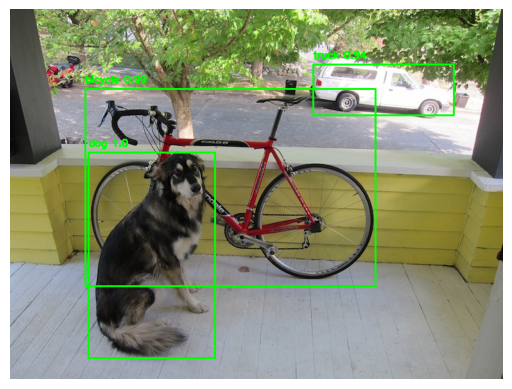

In [11]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
